# Ανάλυση Κατασκεύων σε Η/Υ - Άσκηση 2 (Μαρτ.2021)

In [35]:
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
from tabulate import tabulate
from IPython.display import display, Markdown

## Εισαγωγή αριθμού μητρώου φοιτητών

Αντικαταστήστε τα ψηφία με αυτά του αριθμού μητρώου σας και τρέξτε το jupyter notebook.  
Δε θα χρειαστεί να κάνετε κάποια άλλη αλλαγή ή κάποια εισαγωγή δεδομένων

In [36]:
κ, λ, μ, ν = 8, 0, 5, 4

## Δεδομένα

In [37]:
# Δεδομένα φοιτητών βάσει ΑΕΜ
H=2.7+0.1*(λ+μ)
L=4.5+0.1*(κ+ν)
if ν<5:
    bc=hc=0.45
    bw=0.25
    h=0.65
    hf=0.20
    beff=1.40
else:
    bc=hc=0.50
    bw=0.30
    h=0.70
    hf=0.20
    beff=1.50
bwall=0.25
Lwall=1.7+0.1*ν

F=900.+10*μ+ν
G=15.+λ+ν
Q=8.+ν
   
E=2.8*10**7
U = 0.0

# # # Δεδομένα παραδείγματος βιβλίου
# H=3.0
# L=5.0
# bc=hc=0.4
# bw=0.25
# h=0.70
# hf=0.15
# beff=1.20
# bwall = 0.25
# Lwall = 2.0

# F=1000.
# G=20.
# Q=10.

In [38]:
print(f'H = {H:.2f}m')
print(f'L = {L:.2f}m')
print(f'bc = hc = {bc:.2f}m')
print(f'bw = {bw:.2f}m')
print(f'h = {h:.2f}m')
print(f'hf = {hf:.2f}m')
print(f'beff = {beff:.2f}m')
print(f'bwall = {bwall:.2f}m')
print(f'Lwall = {Lwall:.2f}m')

print(f'E = {F:.2f}kN')
print(f'G = {G:.2f}kN/m')
print(f'Q = {Q:.2f}kN/m')

H = 3.20m
L = 5.70m
bc = hc = 0.45m
bw = 0.25m
h = 0.65m
hf = 0.20m
beff = 1.40m
bwall = 0.25m
Lwall = 2.10m
E = 954.00kN
G = 19.00kN/m
Q = 12.00kN/m


## Επίλυση με το OpenSees

In [39]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

U = 0.0
G_shear = E / (2.0*(1.0+U))

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

wall =  RectangularSectionGeometry(b=bwall, h=Lwall)
A_wall = wall.area
Iz_wall = wall.moment_of_inertia_xx * 0.5
Avy_wall = wall.shear_area_2 * 0.5

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, 0., H)
ops.node(3, L, 0.)
ops.node(4, L, H)
ops.node(5, 2*L, 0.)
ops.node(6, 2*L, H)
ops.node(7, L-Lwall/2., H)
ops.node(8, L+Lwall/2., H)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.equalDOF(4, 2, 1)
ops.equalDOF(6, 2, 1)
    
ops.geomTransf('Linear', 1)

# Στύλοι
ops.element('ElasticTimoshenkoBeam', 1, 1, 2, E, G_shear, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 5, 6, E, G_shear, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')

# Τοίχωμα
ops.element('ElasticTimoshenkoBeam', 3, 3, 4, E, G_shear, A_wall, Iz_wall, Avy_wall, 1)  # , '-mass', 0., '-lMass')

# Δοκοί
ops.element('ElasticTimoshenkoBeam', 4, 2, 7, E, G_shear, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 5, 8, 6, E, G_shear, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

# Βραχίονες
ops.element('ElasticTimoshenkoBeam', 6, 7, 4, E, G_shear, 100., 100., 100., 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 7, 4, 8, E, G_shear, 100., 100., 100., 1)  # , '-mass', 0., '-lMass')

results_ele = []
results_node = []

# F Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.load(2, F, 0., 0.)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(7):
    el_num=i+1
    row = ['F', el_num]
    row.extend([i for i in ops.eleForce(el_num)])
    results_ele.append(row)
row_dips = ['F', 2]
row_dips.extend([i for i in ops.nodeDisp(2)])
results_node.append(row_dips)

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()


# G Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -G)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -G)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(7):
    el_num=i+1
    row = ['G', el_num]
    row.extend([i for i in ops.eleForce(el_num)])
    results_ele.append(row)
row_dips = ['G', 2]
row_dips.extend([i for i in ops.nodeDisp(2)])
results_node.append(row_dips)

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()


# Q Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -Q)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -Q)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(7):
    el_num=i+1
    row = ['Q', el_num]
    row.extend([i for i in ops.eleForce(el_num)])
    results_ele.append(row)
row_dips = ['Q', 2]
row_dips.extend([i for i in ops.nodeDisp(2)])
results_node.append(row_dips)

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()



In [40]:
print(results_node)

[['F', 2, 0.003379618706286588, 3.239538858075095e-05, 8.39135532440462e-05], ['G', 2, 1.2766370522309875e-07, -2.071697786346213e-05, -0.00018383305988988347], ['Q', 2, 8.062971237713625e-08, -1.308440707162684e-05, -0.00011610509045675964]]


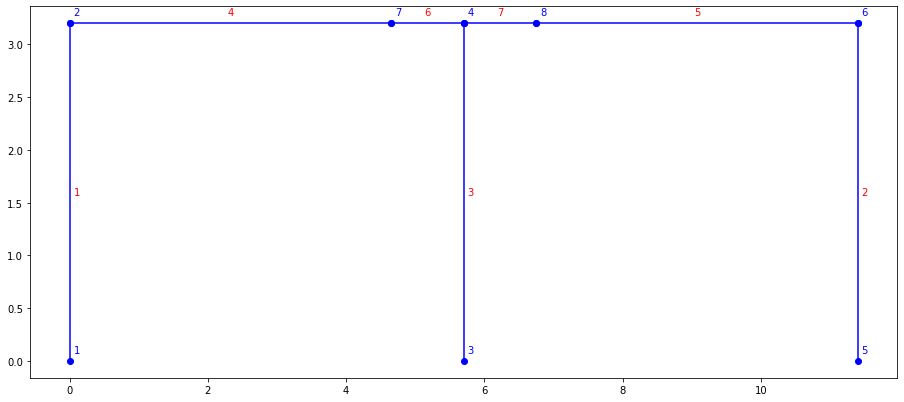

In [41]:
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(left=.08, bottom=.08, right=.94, top=.94)
ax1 = plt.subplot(111)

opsv.plot_model()

## Εμφάνιση αποτελεσμάτων

### Εντατικά μεγέθη για κάθε load pattern

- Στύλοι:
>-Vi, -Ni, Mi, Vj, Nj, -Mj

- Δοκοί:
>-Ni, -Vi, -Mi, Nj, Vj, Mj

In [42]:
print(tabulate(results_ele, headers=["Φόρτιση", "Στοιχείο", 'Fxi', 'Fyi', 'Mzi', 'Fxj', 'Fyj', 'Mzj'], floatfmt=".2f", tablefmt='pipe'))

| Φόρτιση   |   Στοιχείο |     Fxi |    Fyi |     Mzi |    Fxj |     Fyj |     Mzj |
|:----------|-----------:|--------:|-------:|--------:|-------:|--------:|--------:|
| F         |          1 |  -58.77 | -57.40 |   92.78 |  58.77 |   57.40 |   95.29 |
| F         |          2 |  -58.45 |  57.26 |   92.22 |  58.45 |  -57.26 |   94.84 |
| F         |          3 | -836.77 |   0.14 | 2214.25 | 836.77 |   -0.14 |  463.42 |
| F         |          4 |    0.00 | -57.40 |  -95.29 |  -0.00 |   57.40 | -171.62 |
| F         |          5 |   58.45 | -57.26 | -171.41 | -58.45 |   57.26 |  -94.84 |
| F         |          6 |    0.00 | -57.40 |  171.62 |   0.00 |   57.40 | -231.89 |
| F         |          7 |   58.45 | -57.26 | -231.53 | -58.45 |   57.26 |  171.41 |
| G         |          1 |    4.92 |  36.71 |   -5.12 |  -4.92 |  -36.71 |  -10.62 |
| G         |          2 |   -4.90 |  36.70 |    5.08 |   4.90 |  -36.70 |   10.59 |
| G         |          3 |   -0.02 | 103.29 |    0.08 |   0.02 | 

In [43]:
df_results_ele = pd.DataFrame(results_ele, columns=["Φόρτιση", "Στοιχείο", 'Fxi', 'Fyi', 'Mzi', 'Fxj', 'Fyj', 'Mzj'])
df_results_ele.style.set_precision(2)

,Φόρτιση,Στοιχείο,Fxi,Fyi,Mzi,Fxj,Fyj,Mzj
0,F,1,-58.77,-57.40,92.78,58.77,57.40,95.29
1,F,2,-58.45,57.26,92.22,58.45,-57.26,94.84
2,F,3,-836.77,0.14,2214.25,836.77,-0.14,463.42
3,F,4,0.00,-57.40,-95.29,-0.00,57.40,-171.62
4,F,5,58.45,-57.26,-171.41,-58.45,57.26,-94.84
5,F,6,0.00,-57.40,171.62,0.00,57.40,-231.89
6,F,7,58.45,-57.26,-231.53,-58.45,57.26,171.41
7,G,1,4.92,36.71,-5.12,-4.92,-36.71,-10.62
8,G,2,-4.90,36.70,5.08,4.90,-36.70,10.59
9,G,3,-0.02,103.29,0.08,0.02,-103.29,-0.01


In [44]:
cases_groups = df_results_ele.groupby('Φόρτιση')
cases_groups.get_group("F").style.set_precision(2)

,Φόρτιση,Στοιχείο,Fxi,Fyi,Mzi,Fxj,Fyj,Mzj
0,F,1,-58.77,-57.40,92.78,58.77,57.40,95.29
1,F,2,-58.45,57.26,92.22,58.45,-57.26,94.84
2,F,3,-836.77,0.14,2214.25,836.77,-0.14,463.42
3,F,4,0.00,-57.40,-95.29,-0.00,57.40,-171.62
4,F,5,58.45,-57.26,-171.41,-58.45,57.26,-94.84
5,F,6,0.00,-57.40,171.62,0.00,57.40,-231.89
6,F,7,58.45,-57.26,-231.53,-58.45,57.26,171.41


In [45]:
cases_groups.get_group("G").set_index('Στοιχείο')+cases_groups.get_group("Q").set_index('Στοιχείο')

,Φόρτιση,Fxi,Fyi,Mzi,Fxj,Fyj,Mzj
Στοιχείο,,,,,,,
1,GQ,8.023308e+00,59.891829,-8.353159,-8.023308e+00,-59.891829,-17.321427
2,GQ,-7.987622e+00,59.880705,8.288282,7.987622e+00,-59.880705,17.272107
3,GQ,-3.568640e-02,168.527466,0.128281,3.568640e-02,-168.527466,-0.014085
4,GQ,2.049999e-12,59.891829,17.321427,-2.049999e-12,84.258171,-73.973172
5,GQ,7.987622e+00,84.269295,73.975577,-7.987622e+00,59.880705,-17.272107
6,GQ,-2.313016e-09,-84.258171,73.973172,2.313016e-09,84.258171,-162.444252
7,GQ,7.987622e+00,84.269295,162.458337,-7.987622e+00,-84.269295,-73.975577


### Αποτελέσματα εντατικών μεγεθών για τα ζητούμενα της εκφώνησης

In [46]:
# print('Για 1.35G+1.5Q')
# print(f'M_A= {(1.35*results_ele[3][2][2] + 1.5*results_ele[6][2][2]):.2f}kNm')
# print(f'M_B= {(1.35*results_ele[4][2][2] + 1.5*results_ele[7][2][2]):.2f}kNm')
# print(f'M_C= {(-1)*(1.35*results_ele[5][2][2] + 1.5*results_ele[8][2][2]):.2f}kNm')
# print(f'M_D= {(1.35*results_ele[5][2][5] + 1.5*results_ele[8][2][5]):.2f}kNm')
# print()
# print('Για G+0.3Q+E')
# print(f'M_A= {(results_ele[3][2][2] + 0.3*results_ele[6][2][2] + results_ele[0][2][2]):.2f}kNm')
# print(f'M_B= {(results_ele[4][2][2] + 0.3*results_ele[7][2][2] + results_ele[1][2][2]):.2f}kNm')
# print(f'M_C= {(-1)*(results_ele[5][2][2] + 0.3*results_ele[8][2][2] + results_ele[2][2][2]):.2f}kNm')
# print(f'M_D= {(results_ele[5][2][5] + 0.3*results_ele[8][2][5] + results_ele[2][2][5]):.2f}kNm')

### Μετακινήσεις για τα load patterns

In [47]:
df_results_node = pd.DataFrame(results_node, columns=["Φόρτιση", "Κόμβος", 'δx', 'δy', 'rot'])
df_results_node.style.set_precision(4)

,Φόρτιση,Κόμβος,δx,δy,rot
0,F,2,0.0034,0.0000,0.0001
1,G,2,0.0000,-0.0000,-0.0002
2,Q,2,0.0000,-0.0000,-0.0001


### Αποτελέσματα μετακινήσεων για τα ζητούμενα της εκφώνησης

In [48]:
# print('Για 1.35G+1.5Q')
# print(f'δ=0.0cm')
# print()
# print('Για G+0.3Q+E')
# print(f'δ={(1000*results_node[0][1][0]):.2f}mm')

In [49]:
# for re in results_ele:
#     print(f'Για φόρτιση {re[0]}, στο στοιχείο {re[1]}: {np.round(re[2],2)}')

In [50]:
# re = results_ele[0]
# print(f'Για φόρτιση {re[0]}, στο στοιχείο {re[1]}: {np.round(re[2],2)}')

In [51]:
# row = [re[0], re[1]]
# row.extend([i for i in re[2]])
# row